In [1]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import pandas as pd

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.special import factorial, euler
from scipy.interpolate import interp1d
import scipy.stats 
from scipy.optimize import curve_fit
# import dateutil
# import ftplib
# import io
# import datetime
# import time
# import requests
import statsmodels.formula.api as smformula
import statsmodels.api as sm

import itertools
from collections import OrderedDict

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from IPython.display import display, HTML, Markdown
%matplotlib notebook
plt.style.use('seaborn-paper')
mpl.rcParams['figure.facecolor'] = 'lightgray'

In [3]:
# Misc utility functions
def tempF2C(x): return (x-32.0)*5.0/9.0
def tempC2F(x): return (x*9.0/5.0)+32.0


In [22]:
# Parameters
# fn = r'C:\Users\Travis Collier\Desktop\proj\ddtool\testfiles\USDA-WS6\20148981___Over_the_last_week_2018_04_30_22_07_39_UTC_1_pt1.csv'
TEMPERATURE_FILENAME = r'C:\Users\Travis Collier\Desktop\proj\ddtool\testfiles\single_file.csv'

HOUR_OFFSET = -7  # UTC to localtime offset so days are started at local midnight (not worrying about DST)
BASE_TEMP = tempF2C(54.3)
DD_PER_GEN = 622*5/9 # generation time in cumulative degree days

In [129]:
df = pd.read_csv(TEMPERATURE_FILENAME, parse_dates=['Date']).dropna()
tcol = [x for x in df.columns if x.startswith('Temperature ')]
if len(tcol) < 1:
    print("ERROR: Temperature column not found", file=sys.stderr)
else:
    tmp = [x.strip() for x in tcol[0].split(',')]
    station = tmp[-1]
    print(tmp, station)
    
    t = df.loc[:,['Date',tcol[0]]]
    t.set_index('Date', inplace=True)
    t.columns = ['T']
    t.sort_index(inplace=True)
    #t['station'] = station
    first = t.index[0]
    last = t.index[-1]
    
    print(station, first, last)
display(t.shape)
display(t.head())
df = t.copy(deep=True)

# @TCC TEMP : test handling of missing data
# df.drop(df.loc['2018-04-25 07:00:00':'2018-04-27 06:59:59'].index, inplace=True)

['Temperature (S-THB 20148981:20147576-1)', '*C', 'USDA-WS6'] USDA-WS6
USDA-WS6 2018-04-24 07:00:00 2018-04-30 06:55:00


(1728, 1)

,T
Date,
2018-04-24 07:00:00,20.32
2018-04-24 07:05:00,20.34
2018-04-24 07:10:00,20.34
2018-04-24 07:15:00,20.34
2018-04-24 07:20:00,20.36


In [130]:
t = df.copy(deep=True)
t.index = t.index+pd.Timedelta(HOUR_OFFSET, unit='h')
display(t.head())

grp = t.groupby(pd.TimeGrouper('D'))
tmin = np.min(grp)
tmax = np.max(grp)
mmt = tmin.merge(tmax, left_index=True, right_index=True, suffixes=['min','max'])
mmt['Tave'] = (tmin+tmax)/2.0
mmt['N'] = grp.count()
mmt

,T
Date,
2018-04-24 00:00:00,20.32
2018-04-24 00:05:00,20.34
2018-04-24 00:10:00,20.34
2018-04-24 00:15:00,20.34
2018-04-24 00:20:00,20.36


,Tmin,Tmax,Tave,N
Date,,,,
2018-04-24,18.08,25.77,21.925,288
2018-04-25,18.06,26.52,22.290,288
2018-04-26,18.46,23.06,20.760,288
2018-04-27,18.75,26.72,22.735,288
2018-04-28,19.10,24.92,22.010,288
2018-04-29,18.70,21.41,20.055,288


<IPython.core.display.Javascript object>


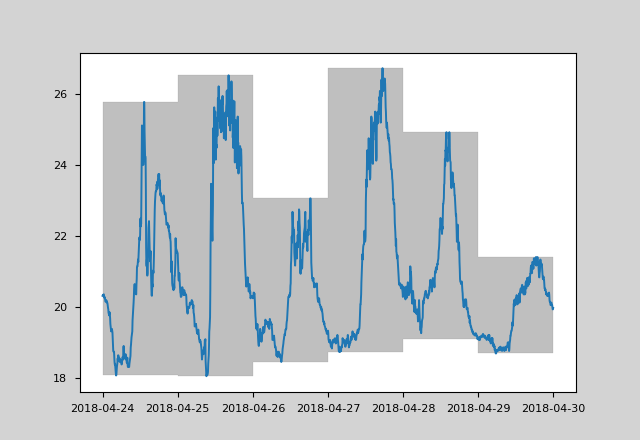

In [131]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = np.dstack((mmt.index.values, (mmt.index+pd.Timedelta(1,unit='d')).values)).flatten()
tmin = mmt['Tmin'].values.repeat(2)
tmax = mmt['Tmax'].values.repeat(2)
ax.fill_between(x, tmin, tmax, color='gray', alpha=0.5)
# ax.plot(x, tmin, 'b.-')#color='blue', alpha=0.5)
# ax.plot(x, tmax, 'r.-')#color='red', alpha=0.5)

ax.plot(t.index, t['T'])

TODO : figure out a way to drop partial days...

In [152]:
# Function which computes BM (single sine method) degree day generation from temperature data
def compute_BMDD_Fs(tmin, tmax, base_temp, dd_gen=None, skipna=False):
    def _compute_daily_BM_DD(mint, maxt, avet, base_temp):
        """Use standard Baskerville-Ermin (single sine) degree-day method
        to compute the degree-day values for each a single day.
        """
        if avet is None:
            avet = (mint+maxt)/2.0 # simple midpoint (like in the refs)
        dd = np.nan # value which we're computing
        # Step 1: Adjust for observation time; not relevant
        # Step 2: GDD = 0 if max < base (curve all below base)
        if maxt < base_temp:
            dd = 0
        # Step 3: Calc mean temp for day; already done previously
        # Step 4: min > base; then whole curve counts
        elif mint >= base_temp:
            dd = avet - base_temp
        # Step 5: else use curve minus part below base
        else:
            W = (maxt-mint)/2.0
            tmp = (base_temp-avet) / W
            if tmp < -1:
                print('WARNING: (base_temp-avet)/W = {} : should be [-1:1]'.format(tmp))
                tmp = -1
            if tmp > 1:
                print('WARNING: (base_temp-avet)/W = {} : should be [-1:1]'.format(tmp))
                tmp = 1
            A = np.arcsin(tmp)
            dd = ((W*np.cos(A))-((base_temp-avet)*((np.pi/2.0)-A)))/np.pi
        return dd
    # compute the degree-days for each day in the temperature input (from tmin and tmax vectors)
    dd = pd.concat([tmin,tmax], axis=1)
    dd.columns = ['tmin', 'tmax']
    dd['DD'] = dd.apply(lambda x: _compute_daily_BM_DD(x[0], x[1], (x[0]+x[1])/2.0, base_temp), axis=1)
    dd['DD_cum'] = dd['DD'].cumsum(skipna=skipna)   
    # add generation number if we are given DD per generation (dd_gen)
    if dd_gen:
        dd['gen'] = np.floor(dd['DD_cum']/dd_gen).astype(int)
    return dd

In [156]:
dd = compute_BMDD_Fs(mmt['Tmin'], mmt['Tmax'], BASE_TEMP, 20)#DD_PER_GEN)
dd

,tmin,tmax,DD,DD_cum,gen
Date,,,,,
2018-04-24,18.08,25.77,9.536111,9.536111,0
2018-04-25,18.06,26.52,9.901111,19.437222,0
2018-04-26,18.46,23.06,8.371111,27.808333,1
2018-04-27,18.75,26.72,10.346111,38.154444,1
2018-04-28,19.10,24.92,9.621111,47.775556,2
2018-04-29,18.70,21.41,7.666111,55.441667,2


In [140]:
np.floor(dd['DD_cum']/20).astype(int)

Date
2018-04-24    0
2018-04-25    0
2018-04-26    1
2018-04-27    1
2018-04-28    2
2018-04-29    2
Freq: D, Name: DD_cum, dtype: int32